In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [796]:
# load the data in training_dictionary.txt
with open("training_dictionary.txt", "r") as file:
    all_words = file.read().splitlines()

100%|██████████| 224377/224377 [00:00<00:00, 4448640.02it/s]

count    224377.000000
mean          9.591540
std           2.916634
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          24.000000
Name: word_length, dtype: float64


array([[<Axes: title={'center': 'word_length'}>]], dtype=object)

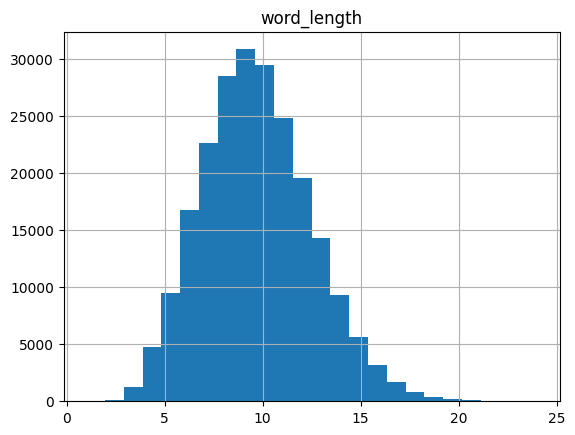

In [800]:
import pandas as pd

df = pd.DataFrame(
    {
        "word_length": [len(word) for word in tqdm(all_words)],
    }
)

print(df["word_length"].describe())

df.hist(column="word_length", bins=df["word_length"].max())

In [863]:
max_length = 12

words = [word for word in all_words if len(word) == max_length]

In [864]:
print(len(words))
words[:10]

19608


['intermammary',
 'constabulary',
 'petrophilous',
 'phaenogamian',
 'rekindlement',
 'rollickingly',
 'demutization',
 'nonstampable',
 'mesaticephal',
 'chakravartin']

In [865]:
len("".join(words))

235296

In [866]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

intermammary 12


In [867]:
vocab = set("".join(words))
vocab = ["_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

27
{'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '_', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [868]:
# create a dataset where each character is masked with an underscore
block_size = max_length
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    # if len(word) < block_size:
    #     word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:10]

19608


['intermammary',
 'constabulary',
 'petrophilous',
 'phaenogamian',
 'rekindlement',
 'rollickingly',
 'demutization',
 'nonstampable',
 'mesaticephal',
 'chakravartin']

In [869]:
def masked_words(word):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word))

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        # for char in chars_to_mask:
        result.append((masked, word))

    return result


print(masked_words("app"))
print(masked_words("xyz"))

[('_pp', 'app'), ('a__', 'app'), ('___', 'app')]
[('xy_', 'xyz'), ('x_z', 'xyz'), ('x__', 'xyz'), ('_yz', 'xyz'), ('_y_', 'xyz'), ('__z', 'xyz'), ('___', 'xyz')]


In [ ]:
dataset = []
for word in truncated_words:
    dataset.extend(masked_words(word))

# dataset = list(set(dataset))

# print the first 10 elements of the dataset
print(len(dataset))
print(dataset[:10])

In [ ]:
# convert the words to a list of ints
integerized_dataset = []
for word, label in dataset:
    integerized_dataset.append(
        ([stoi[char] for char in word], [stoi[char] for char in label])
    )

print(integerized_dataset[0])

([0, 17, 10, 21, 19, 10, 4, 9, 10, 2, 13], [6, 17, 10, 21, 19, 10, 4, 9, 10, 2, 13])


In [ ]:
# create a pytorch dataset of word and label pairs
from torch.utils.data import Dataset
import random


class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


split_idx = int(len(integerized_dataset) * 1)
shuffled_integerized_dataset = list(integerized_dataset)
random.shuffle(shuffled_integerized_dataset)
train_split = shuffled_integerized_dataset[:split_idx]
val_split = shuffled_integerized_dataset[split_idx:]

train_dataset = HangmanDataset(train_split)
val_dataset = HangmanDataset(val_split)

print(len(train_dataset))
print(train_dataset[[0, 1, 2]])

print(len(val_dataset))

12264897
(tensor([[17, 19,  0, 17,  0, 13, 10,  0,  6, 15,  6],
        [18,  0,  0,  0,  0,  0, 15,  3,  0,  2, 14],
        [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0]]), tensor([[17, 19, 16, 17, 26, 13, 10,  5,  6, 15,  6],
        [18, 22, 10,  4, 12,  6, 15,  3,  6,  2, 14],
        [ 4,  9, 19, 16, 14,  2, 17,  9, 16, 19,  6]]))
0


In [858]:
# Create a transformer model for the hangman game

import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

d_model = 256
nhead = 8
num_layers = 3

device = "mps" if torch.backends.mps.is_available() else "cpu"


class HangmanTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0):
        super(HangmanTransformer, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout

        # Create positional encoding matrix
        self.embedding = nn.Embedding(vocab_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.position_embedding_table = nn.Embedding(block_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src)
        pos_emb = self.position_embedding_table(
            torch.arange(block_size).to(device)
        )  # (T,C)
        src = src + pos_emb
        output = self.transformer_encoder(src)
        output = self.ln_f(output)
        logits = self.fc(output)
        return logits


# create a transformer model
model = HangmanTransformer(vocab_size, d_model, nhead, num_layers)

model.to(device)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# train the model
batch_size = 512
num_epochs = 1

lossi = []

for epoch in range(num_epochs):
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        # idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(features)

        # Calculate loss
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
        lossi.append(loss.item())

Epoch 1/1 | Loss: 0.5686:  65%|██████▍   | 15566/23955 [09:25<05:04, 27.51it/s]


KeyboardInterrupt: 

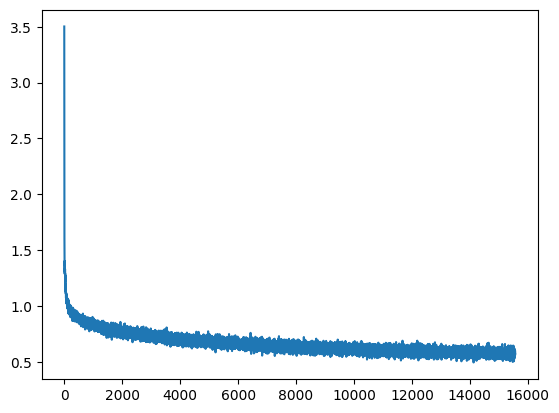

In [ ]:
plt.plot(lossi)
plt.show()

In [860]:
model.eval()
val_dataset = train_dataset[:20000]
with torch.no_grad():
    losses = []
    for i in (pbar := tqdm(range(0, len(val_dataset), batch_size))):
        features, labels = val_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        losses.append(loss.item())
    print(np.mean(losses))

100%|██████████| 1/1 [00:13<00:00, 13.83s/it]

0.5725834965705872


In [861]:
# inference:


def predict(model, word, max_guesses=6, verbose=False):
    if verbose:
        print("word", word)
    guesses = []
    model.eval()
    with torch.no_grad():
        while True:
            # print(guesses)
            masked_word = "".join(
                ["_" if guess not in guesses else guess for guess in word]
            )
            if verbose:
                print("masked_word", masked_word, guesses)
            if masked_word == word:
                break
            if len([g for g in guesses if g not in word]) >= max_guesses:
                break

            features = torch.tensor([[stoi[c] for c in masked_word]]).to(device)
            # print("features", features)
            logits = model.forward(features)
            probs = torch.softmax(logits, dim=2)
            # print("probs", probs)
            # print("max", torch.max(probs, dim=2).values)
            most_confident_index = torch.topk(
                torch.max(probs, dim=2).values, k=len(masked_word), dim=1
            ).indices[0]
            if verbose:
                print("most_confident_index", most_confident_index)
            indices = torch.topk(probs, k=vocab_size - 1, dim=2).indices
            # print("indices", indices)
            for i in most_confident_index:
                if masked_word[i] == "_":
                    letter_guesses = [itos[j.item()] for j in indices[0, i]]
                    break
            if verbose:
                print("letter_guesses", letter_guesses)
            for letter_guess in letter_guesses:
                if letter_guess not in guesses and letter_guess != "_":
                    guesses.append(letter_guess)
                    if (
                        letter_guess in word
                        or len([g for g in guesses if g not in word]) == max_guesses
                    ):
                        break
                    # break
    return masked_word, guesses


predict(model, truncated_words[1], max_guesses=6, verbose=True)

wins = 0
total = 0
for word in (pbar := tqdm(truncated_words)):
    masked_word, guesses = predict(model, word, max_guesses=6, verbose=False)
    if masked_word == word:
        wins += 1
    total += 1
    pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")

# Win Rates
# 2 chars: 31.58% (133)
# 3 chars: 24.10% (1249)
# 4 chars: 23.34% (4798)
# 5 chars: 37.19% (9522)
# 6 chars: 34.19% (16763)
# 7 chars: 43.69% (22675)
# 8 chars: 60.68% (28512)
# 9 chars: 74.61% (30882)

word unscathedly
masked_word ___________ []
most_confident_index tensor([ 8, 10,  1,  6,  9,  0,  4,  2,  5,  7,  3], device='mps:0')
letter_guesses ['i', 'o', 'e', 't', 'a', 'n', 'r', 's', 'l', 'b', 'd', 'c', 'h', 'g', 'u', 'p', 'm', 'z', 'y', 'k', 'f', 'v', 'x', 'w', 'q', 'j', '-']
masked_word _______e___ ['i', 'o', 'e']
most_confident_index tensor([ 7,  9, 10,  8,  4,  0,  5,  6,  3,  1,  2], device='mps:0')
letter_guesses ['i', 'a', 'u', 'l', 'r', 'o', 'c', 't', 's', 'm', 'n', 'y', 'h', 'd', 'g', 'p', 'v', 'z', 'e', 'k', 'f', 'b', 'x', 'w', 'q', 'j', '-']
masked_word ____a__e___ ['i', 'o', 'e', 'a']
most_confident_index tensor([ 7,  4,  9, 10,  1,  0,  8,  3,  2,  5,  6], device='mps:0')
letter_guesses ['i', 'u', 'o', 's', 'l', 'r', 'm', 't', 'y', 'c', 'n', 'd', 'h', 'g', 'f', 'z', 'p', 'k', 'a', 'b', 'v', 'w', 'e', 'x', 'q', 'j', '-']
masked_word u___a__e___ ['i', 'o', 'e', 'a', 'u']
most_confident_index tensor([ 7,  0,  4,  1, 10,  9,  8,  3,  2,  6,  5], device='mps:0')
letter_g

Win rate: 89.70%:  17%|█▋        | 4312/24895 [06:54<32:57, 10.41it/s]  


KeyboardInterrupt: 

63.89121296959437


,word_length,win_rate,num_words
0,2,31.58,133
1,3,24.10,1249
2,4,23.34,4798
3,5,37.19,9522
4,6,34.19,16763
5,7,43.69,22675
6,8,60.68,28512
7,9,74.61,30882
8,10,83.43,29520
9,11,89.70,24895


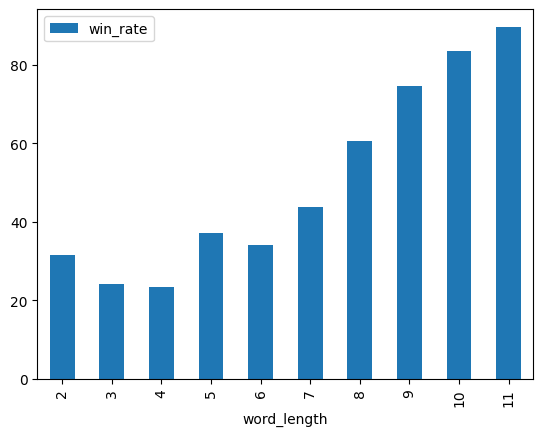

In [862]:
windf = pd.DataFrame(
    {
        "word_length": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        "win_rate": [
            31.58,
            24.10,
            23.34,
            37.19,
            34.19,
            43.69,
            60.68,
            74.61,
            83.43,
            89.70,
        ],
        "num_words": [133, 1249, 4798, 9522, 16763, 22675, 28512, 30882, 29520, 24895],
    }
)
print(windf["win_rate"].mul(windf["num_words"]).sum() / windf["num_words"].sum())
windf.plot.bar(x="word_length", y="win_rate")
windf